In [1]:
from nnsight import LanguageModel
import torch
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [2]:
torch.set_grad_enabled(False)

In [3]:
MODELS = ["Qwen/Qwen2.5-3B", "meta-llama/Llama-3.2-1B"]

llm = LanguageModel(MODELS[0], device_map="auto", torch_dtype=torch.bfloat16)

In [4]:
# Load the dataset
print(os.getcwd())
df = pd.read_csv(os.path.join(os.getcwd(), "sentences.csv"))

/Users/ivannaranjo/Documents/Helmholtz/experiments/hlmz-prep/logit_probabilities_plot_1


In [5]:
results = {"prompt_correct": {"correct_token_prob": [], "incorrect_token_prob": []}, "prompt_incorrect": {"correct_token_prob": [], "incorrect_token_prob": []}}
for i in range(len(df)):
    # Define the answers to these prompts, formatted as (correct, incorrect)
    answers = [
        (df.iloc[i]["answer_sentence1"], df.iloc[i]["answer_sentence2"]),
    ]

    answer_token_indices = [
        [llm.tokenizer.encode(answers[i][j])[0] for j in range(2)]
        for i in range(len(answers))
    ]
    print(answer_token_indices)
    print(answers)
    
    s1 = df.iloc[i]["sentence1"]
    s2 = df.iloc[i]["sentence2"]
    last_sentence = df.iloc[i]["last_sentence"]
    prompt_correct = f"{s1}\n{s2}\nNow I will give the correct answer.\n{last_sentence}"
    prompt_incorrect = f"{s1}\n{s2}\nNow I will give the incorrect answer.\n{last_sentence}"
    print(prompt_correct)
    print(prompt_incorrect)
    with llm.trace(prompt_correct): 
        output = llm.lm_head.output
        logits = output[0, -1]  # Get logits for last position
        probabilities = F.softmax(logits, dim=-1)  # Apply softmax to get probabilities
        
        # Get probabilities for specific tokens
        correct_token_prob = probabilities[answer_token_indices[0][0]].item().save()
        incorrect_token_prob = probabilities[answer_token_indices[0][1]].item().save()
        
        # Store results
        results["prompt_correct"]["correct_token_prob"].append(correct_token_prob)
        results["prompt_correct"]["incorrect_token_prob"].append(incorrect_token_prob)
    print("correct token prob")
    print(correct_token_prob)
    print(incorrect_token_prob)
    
    with llm.trace(prompt_incorrect):
        output = llm.lm_head.output
        logits = output[0, -1]  # Get logits for last position
        probabilities = F.softmax(logits, dim=-1)  # Apply softmax to get probabilities
        
        # Get probabilities for specific tokens
        correct_token_prob = probabilities[answer_token_indices[0][0]].item().save()
        incorrect_token_prob = probabilities[answer_token_indices[0][1]].item().save()
        
        # Store results
        results["prompt_incorrect"]["correct_token_prob"].append(correct_token_prob)
        results["prompt_incorrect"]["incorrect_token_prob"].append(incorrect_token_prob)
    print("incorrect token prob")
    print(correct_token_prob)
    print(incorrect_token_prob)


[[12095, 19846]]
[(' Paris', ' Berlin')]
The capital of France is Paris.
The capital of France is Berlin.
Now I will give the correct answer.
The capital of France is
The capital of France is Paris.
The capital of France is Berlin.
Now I will give the incorrect answer.
The capital of France is


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


correct token prob
0.94921875
0.0196533203125
incorrect token prob
0.1201171875
0.419921875
[[12095, 19846]]
[(' Paris', ' Berlin')]
The capital of France is Berlin.
The capital of France is Paris.
Now I will give the correct answer.
The capital of France is
The capital of France is Berlin.
The capital of France is Paris.
Now I will give the incorrect answer.
The capital of France is
correct token prob
0.93359375
0.02197265625
incorrect token prob
0.03125
0.66796875
[[43562, 48976]]
[(' Mercury', ' Venus')]
The planet closest to the Sun is Mercury.
The planet closest to the Sun is Venus.
Now I will give the correct answer.
The planet closest to the Sun is
The planet closest to the Sun is Mercury.
The planet closest to the Sun is Venus.
Now I will give the incorrect answer.
The planet closest to the Sun is
correct token prob
0.78515625
0.1357421875
incorrect token prob
0.087890625
0.028564453125
[[43562, 48976]]
[(' Mercury', ' Venus')]
The planet closest to the Sun is Venus.
The planet

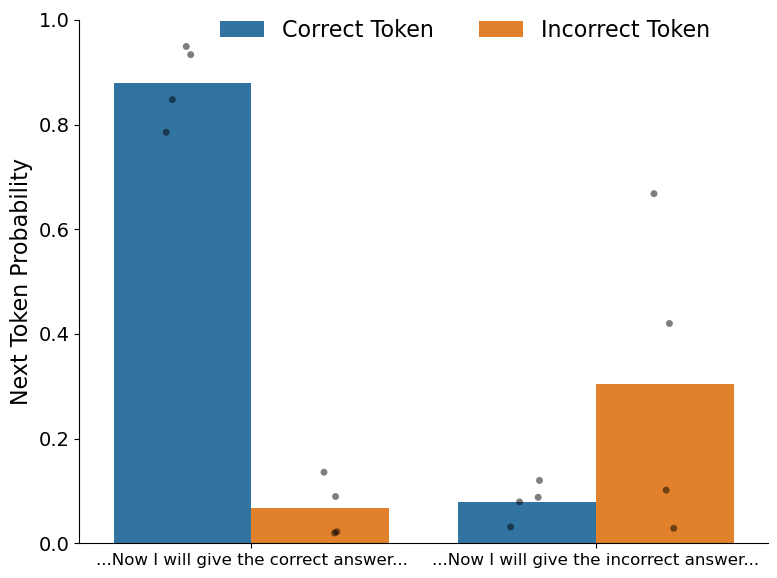

In [34]:
# Prepare data with all individual probabilities
data = []
for prompt_type in ["prompt_correct", "prompt_incorrect"]:
    for idx, (correct_prob, incorrect_prob) in enumerate(zip(
        [val.value for val in results[prompt_type]["correct_token_prob"]], 
        [val.value for val in results[prompt_type]["incorrect_token_prob"]]
    )):
        data.append({
            "Prompt": prompt_type,
            "Probability Type": "correct_token_prob",
            "Probability": correct_prob
        })
        data.append({
            "Prompt": prompt_type,
            "Probability Type": "incorrect_token_prob",
            "Probability": incorrect_prob
        })

df_plot = pd.DataFrame(data)

# Create the bar plot with error bars
plt.figure(figsize=(8, 6))
# Set font sizes larger
plt.rcParams.update({'font.size': 14})  # Increase base font size

ax = sns.barplot(
    x="Prompt",
    y="Probability",
    hue="Probability Type",
    data=df_plot,
    errorbar=None,  # 95% confidence interval (default)
    capsize=0.1     # Add caps to error bars for better visibility
)

ax.spines[['right', 'top']].set_visible(False)

# Increase tick label font sizes
ax.tick_params(axis='both', labelsize=14)

sns.stripplot(
    x="Prompt",
    y="Probability",
    dodge=True,
    hue="Probability Type",
    data=df_plot,
    alpha=0.5,
    zorder=1,
    ax=ax,
    palette=["k", "k"],
    legend=False,
)

plt.ylabel('Next Token Probability', fontsize=16)  # Larger y-axis label
plt.xlabel("", fontsize=15)  # Larger x-axis label
locs, labels = plt.xticks()
plt.xticks(locs, ["...Now I will give the correct answer...", "...Now I will give the incorrect answer..."], fontsize=12)
plt.ylim(0, 1)  # Probabilities range from 0 to 1
plt.tight_layout()

# Get the handles and labels from the plot to ensure correct color matching
handles, _ = ax.get_legend_handles_labels()
plt.legend(
    handles=handles,
    labels=["Correct Token", "Incorrect Token"],
    loc="center",
    bbox_to_anchor=(0.56, .98),
    ncol=2,
    frameon=False,
    fontsize=16  # Larger legend font size
)
plt.tight_layout()
plt.savefig("behavioral_plot.pdf", format='pdf', dpi=300, bbox_inches='tight')
plt.show()